## Analyzing the dataset

In [2]:
import pandas as pd

df = pd.read_csv('Reviews.csv')

print("Columns:", df.columns.tolist())
print("\nData info:")
print(df.info())

print("\nSample data:")
print(df.head())

# Identify text and non-text columns by dtype
text_cols = df.select_dtypes(include=['object']).columns.tolist()

for col in df.columns:
    print(f"\nColumn: '{col}'")
    if col in text_cols:
        # For text columns, print length stats
        lengths = df[col].dropna().apply(lambda x: len(str(x).split()))
        print(f"Text length stats (word counts):\n{lengths.describe()}")
    else:
        # For non-text columns, print top 10 unique values
        print(f"Top 10 unique values:\n{df[col].value_counts(dropna=False).head(10)}")


Columns: ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB
None

Sample data:
   Id   ProductId          User

## 1. Binarize labels
## 2. Minimal cleaning on Text
## 3. Split data into train/test with stratification

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re

# Step 1: Binarize Scores into sentiment labels
# 4,5 => 1 (positive), 1,2,3 => 0 (negative)
df['sentiment'] = np.where(df['Score'] >= 4, 1, 0)

# Check class balance
print("Class distribution after binarization:")
print(df['sentiment'].value_counts(normalize=True))

# Step 2: Minimal text cleaning function
def clean_text(text):
    text = str(text).lower()  # Lowercase
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetic chars
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

df['clean_text'] = df['Text'].apply(clean_text)

print("\nSample cleaned text:")
print(df['clean_text'].head())

# Step 3: Train-test split (stratified)
X = df['clean_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTrain size:", X_train.shape[0])
print("Test size:", X_test.shape[0])
print("Train class distribution:")
print(y_train.value_counts(normalize=True))
print("Test class distribution:")
print(y_test.value_counts(normalize=True))


Class distribution after binarization:
sentiment
1    0.780674
0    0.219326
Name: proportion, dtype: float64

Sample cleaned text:
0    i have bought several of the vitality canned d...
1    product arrived labeled as jumbo salted peanut...
2    this is a confection that has been around a fe...
3    if you are looking for the secret ingredient i...
4    great taffy at a great price there was a wide ...
Name: clean_text, dtype: object

Train size: 454763
Test size: 113691
Train class distribution:
sentiment
1    0.780673
0    0.219327
Name: proportion, dtype: float64
Test class distribution:
sentiment
1    0.780677
0    0.219323
Name: proportion, dtype: float64


## Tokenization and Padding:

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
vocab_size = 10000  # top 10k words in vocab
max_seq_length = 100  # max words per review

# Initialize tokenizer and fit on training text only
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to fixed length
X_train_padded = pad_sequences(train_sequences, maxlen=max_seq_length, padding='post', truncating='post')
X_test_padded = pad_sequences(test_sequences, maxlen=max_seq_length, padding='post', truncating='post')

print("Example sequence (before padding):", train_sequences[0][:20])
print("Padded sequence shape:", X_train_padded.shape)


2025-09-23 10:07:14.983266: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-23 10:07:15.304753: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-23 10:07:16.440804: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Example sequence (before padding): [50, 17, 275, 27, 302, 368, 10, 584, 77, 109, 103, 142, 7, 58, 8, 2, 2872, 4, 579, 2]
Padded sequence shape: (454763, 100)


## Building the architecture

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense

# Hyperparameters
embedding_dim = 64
max_length = 100
batch_size = 128
epochs = 5
vocab_size = 10000

def build_model(recurrent_layer):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(recurrent_layer)
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Define the three recurrent layers
rnn_layer = SimpleRNN(64)
lstm_layer = LSTM(64)
gru_layer = GRU(64)

# Build models with the respective recurrent layers
model_rnn = build_model(rnn_layer)
model_lstm = build_model(lstm_layer)
model_gru = build_model(gru_layer)

# Train each model for 5 epochs
print("Training SimpleRNN model...")
history_rnn = model_rnn.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size,
                            validation_data=(X_test_padded, y_test))

print("\nTraining LSTM model...")
history_lstm = model_lstm.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size,
                              validation_data=(X_test_padded, y_test))

print("\nTraining GRU model...")
history_gru = model_gru.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size,
                           validation_data=(X_test_padded, y_test))


Training SimpleRNN model...
Epoch 1/5


2025-09-23 10:15:46.877274: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/ai-a3/.local/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3553/3553 ━━━━━━━━━━━━━━━━━━━━ 45s 12ms/step - accuracy: 0.7852 - loss: 0.5117 - val_accuracy: 0.7922 - val_loss: 0.5017
Epoch 2/5
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.7981 - loss: 0.4870 - val_accuracy: 0.7878 - val_loss: 0.4983
Epoch 3/5
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.8062 - loss: 0.4606 - val_accuracy: 0.7932 - val_loss: 0.4897
Epoch 4/5
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.8169 - loss: 0.4454 - val_accuracy: 0.7932 - val_loss: 0.5019
Epoch 5/5
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.8238 - loss: 0.4327 - val_accuracy: 0.7910 - val_loss: 0.5176

Training LSTM model...
Epoch 1/5
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 132s 37ms/step - accuracy: 0.8501 - loss: 0.3586 - val_accuracy: 0.9036 - val_loss: 0.2363
Epoch 2/5
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 125s 35ms/step - accuracy: 0.9157 - loss: 0.2107 - val_accuracy: 0.9189 - val_loss: 0.2052
Epoch 3/5
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 126s 35ms/step - accuracy:

## Evaluation, plotting training history comparison.

Test accuracy:
SimpleRNN: 0.7910
LSTM: 0.9302
GRU: 0.9319


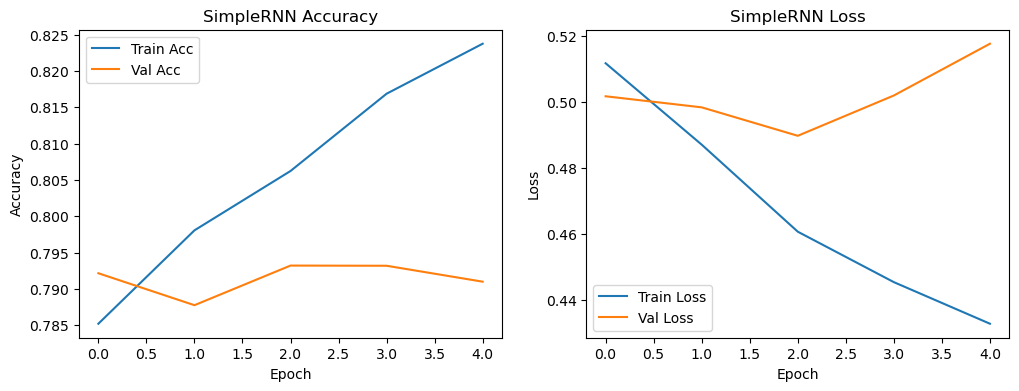

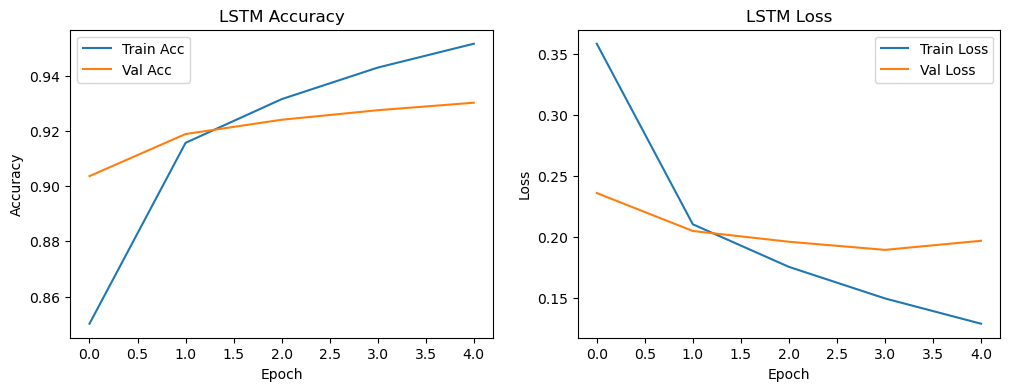

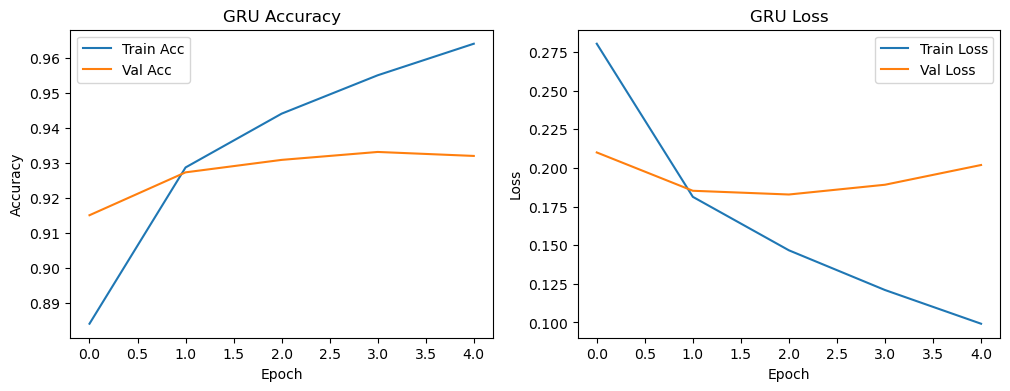

Summary of test accuracies:
Model      Test Accuracy  
SimpleRNN  0.7910         
LSTM       0.9302         
GRU        0.9319         

- SimpleRNN is basic, prone to vanishing gradients, and better for simple or smaller datasets.
- LSTM can capture long-term dependencies via gating mechanisms but is computationally heavier.
- GRU is a simplified LSTM variant with fewer parameters, often faster and similarly effective.
- Use RNN for simple tasks, LSTM for complex sequences needing long-term memory, and GRU for a balance of performance and speed.



In [7]:
import matplotlib.pyplot as plt
import time

# Evaluate models on test data
rnn_eval = model_rnn.evaluate(X_test_padded, y_test, verbose=0)
lstm_eval = model_lstm.evaluate(X_test_padded, y_test, verbose=0)
gru_eval = model_gru.evaluate(X_test_padded, y_test, verbose=0)

print("Test accuracy:")
print(f"SimpleRNN: {rnn_eval[1]:.4f}")
print(f"LSTM: {lstm_eval[1]:.4f}")
print(f"GRU: {gru_eval[1]:.4f}")

# Plot training and validation accuracy and loss
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history_rnn, "SimpleRNN")
plot_history(history_lstm, "LSTM")
plot_history(history_gru, "GRU")

# Summary comparison
print("Summary of test accuracies:")
print(f"{'Model':<10} {'Test Accuracy':<15}")
print(f"{'SimpleRNN':<10} {rnn_eval[1]:<15.4f}")
print(f"{'LSTM':<10} {lstm_eval[1]:<15.4f}")
print(f"{'GRU':<10} {gru_eval[1]:<15.4f}")




# Discussion on when to use RNN vs LSTM vs GRU

- SimpleRNN is basic, prone to vanishing gradients, and better for simple or smaller datasets.
- LSTM can capture long-term dependencies via gating mechanisms but is computationally heavier.
- GRU is a simplified LSTM variant with fewer parameters, often faster and similarly effective.
- Use RNN for simple tasks, LSTM for complex sequences needing long-term memory, and GRU for a balance of performance and speed.
